In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.externals import joblib

In [4]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data from file

In [6]:
merged_data = pd.read_pickle('merged_data_pct_change.pkl')

In [7]:
filtered_merged_data = merged_data[merged_data['1day relative pct change'].abs() > 3.]

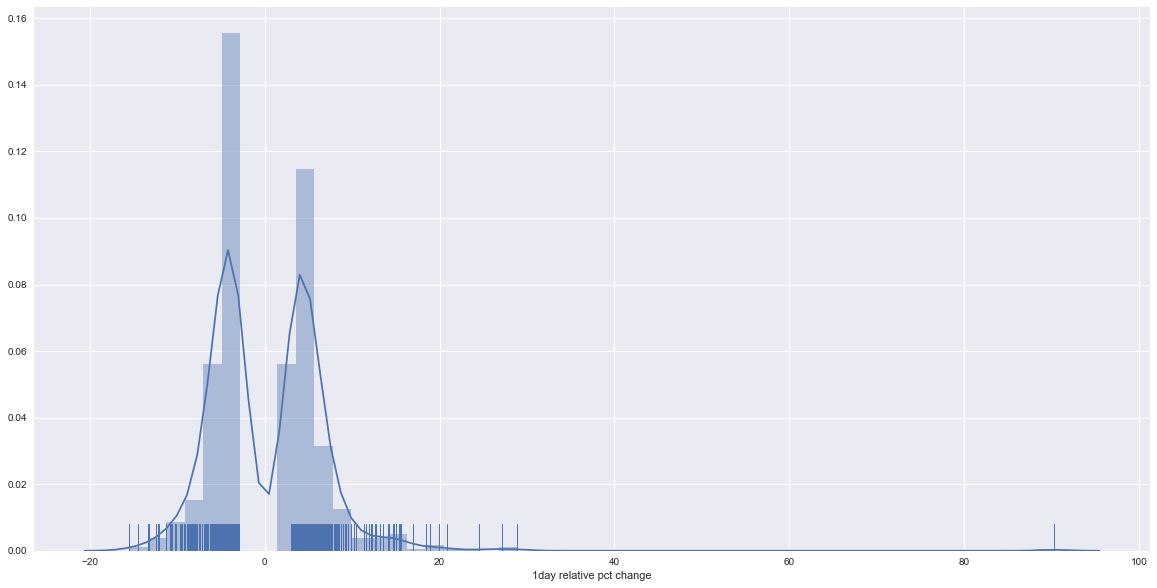

In [8]:
plt.figure(figsize=(20,10))
sns.distplot(filtered_merged_data['1day relative pct change'], bins=50, rug=True)

In [9]:
len(filtered_merged_data)

869

# Create train data and test data

In [10]:
X = filtered_merged_data['rawText']
y = filtered_merged_data['1day relative pct change'] > 0

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Tf-Idf

### Load from file

In [12]:
#tfidf = joblib.load('tfidf_lemmatokenizer__maxdf0_4__mindf300.pkl')

In [13]:
#tfidf_vectors = tfidf.transform(X_train)

### Recreate vectorizer from scratch

In [14]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t.lower(), 'v') for t in word_tokenize(doc)]

In [15]:
tfidf = TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1,2),tokenizer=LemmaTokenizer(), stop_words='english')
svd = TruncatedSVD(300)
lsa = make_pipeline(tfidf, svd)

# Run SVD on the training data, then project the training data.
lsa_vectors = lsa.fit_transform(X_train)

In [16]:
lsa_vectors.shape

(695, 300)

In [17]:
#joblib.dump(tfidf, 'tfidf_lemmatokenizer__maxdf0_4__mindf300.pkl')

# DNN model

In [27]:
# define base model
def baseline_model():
    model = Sequential()
    model.add(Dense(50, input_dim=lsa_vectors.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [28]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=5, verbose=2)

In [29]:
estimator.fit(lsa_vectors, y_train)

Epoch 1/50
1s - loss: 0.6934 - acc: 0.4921
Epoch 2/50
0s - loss: 0.6933 - acc: 0.4849
Epoch 3/50
0s - loss: 0.6888 - acc: 0.5525
Epoch 4/50
0s - loss: 0.6588 - acc: 0.6849
Epoch 5/50
0s - loss: 0.5871 - acc: 0.7482
Epoch 6/50
0s - loss: 0.5128 - acc: 0.7914
Epoch 7/50
0s - loss: 0.4556 - acc: 0.8158
Epoch 8/50
0s - loss: 0.4132 - acc: 0.8230
Epoch 9/50
0s - loss: 0.3792 - acc: 0.8489
Epoch 10/50
0s - loss: 0.3514 - acc: 0.8561
Epoch 11/50
0s - loss: 0.3213 - acc: 0.8676
Epoch 12/50
0s - loss: 0.2957 - acc: 0.8849
Epoch 13/50
0s - loss: 0.2736 - acc: 0.8993
Epoch 14/50
0s - loss: 0.2451 - acc: 0.9108
Epoch 15/50
0s - loss: 0.2146 - acc: 0.9353
Epoch 16/50
0s - loss: 0.2069 - acc: 0.9194
Epoch 17/50
0s - loss: 0.1854 - acc: 0.9266
Epoch 18/50
0s - loss: 0.1637 - acc: 0.9453
Epoch 19/50
0s - loss: 0.1501 - acc: 0.9468
Epoch 20/50
0s - loss: 0.1320 - acc: 0.9496
Epoch 21/50
0s - loss: 0.1208 - acc: 0.9554
Epoch 22/50
0s - loss: 0.0958 - acc: 0.9640
Epoch 23/50
0s - loss: 0.0906 - acc: 0.96

In [30]:
test_vectors = lsa.transform(X_test)

In [31]:
test_vectors.shape

(174, 300)

In [32]:
y_predicted = estimator.predict(test_vectors)

In [33]:
print(classification_report(y_test, y_predicted))

             precision    recall  f1-score   support

      False       0.54      0.57      0.55        92
       True       0.49      0.46      0.48        82

avg / total       0.52      0.52      0.52       174



In [34]:
cm = confusion_matrix(y_test, y_predicted)

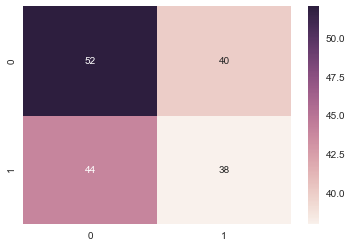

In [35]:
sns.heatmap(cm, annot=True)